Beale synthetic function:

GP ERM versus GP dERM (winner)

https://www.sfu.ca/~ssurjano/beale.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
### Inputs:

obj_func = 'Beale'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'ERM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Beale':

    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb = -4.5
    ub = +4.5

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return  operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2
                )


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM': self.ERM
        }

        self.f = mode_dict[mode]

    def ERM(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.74680196  1.98292044]	 6.5970295	 6.5970295	     	     	     	     	    
init	 [-4.49897063 -1.77900685]	 1305.47105896	 6.5970295	     	     	     	     	    
init	 [-3.17919698 -3.66895265]	 28173.77601348	 6.5970295	     	     	     	     	    
init	 [-2.8236581  -1.38995346]	 237.99317641	 6.5970295	     	     	     	     	    
init	 [-0.92909273  0.34935061]	 26.17906318	 6.5970295	     	     	     	     	    
1  	 [-2.52382181 -0.50243819]	 75.02560376	 6.5970295	 26.4 	 114.05454927 	 116.41909428 	 0.98 	 10.329
2  	 [4.30710061 4.5       ]	 160253.78777695	 6.5970295	 23.7 	 0.79788456 	 0.79788455 	 1.0 	 8.344
3  	 [ 3.38561684 -2.60084398]	 4227.06583216	 6.5970295	 21.9 	 0.79787885 	 0.79788337 	 1.0 	 9.879
4  	 [-2.50840694 -0.55073304]	 75.86071974	 6.5970295	 10.0 	 0.79771348 	 28.8361734 	 0.028 	 5.335
5  	 [-4.5  4.5]	 169680.83203125	 6.5970295	 15.9 

In [15]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.57604588 -4.26666391]	 2377.84417418	 8.81624267	     	     	     	     	    
init	 [ 0.4469623  -0.58209847]	 8.81624267	 8.81624267	     	     	     	     	    
init	 [-0.71668978 -1.52698661]	 47.37426285	 8.81624267	     	     	     	     	    
init	 [-2.65816229  1.0734387 ]	 9.0886159	 8.81624267	     	     	     	     	    
init	 [-1.80310794 -2.09855452]	 510.22209437	 8.81624267	     	     	     	     	    
1  	 [ 0.24985681 -0.61802135]	 10.95666928	 8.81624267	 20.2 	 0.79788395 	 0.9232796 	 0.864 	 9.247
2  	 [2.76492634 4.5       ]	 66612.67125563	 8.81624267	 29.8 	 0.79788444 	 0.7978838 	 1.0 	 13.626
3  	 [ 4.5        -2.31841352]	 4020.14478027	 8.81624267	 24.6 	 0.79680455 	 0.79741712 	 0.999 	 13.244
4  	 [-4.5  4.5]	 169680.83203125	 8.81624267	 9.3 	 0.69833046 	 0.79682223 	 0.876 	 8.702
5  	 [-2.00936545  0.7526723 ]	 27.99875715	 8.81624267	 8.8

In [16]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.45718112 1.8733304 ]	 41.91271474	 41.91271474	     	     	     	     	    
init	 [-1.88185735  0.09744845]	 47.45118839	 41.91271474	     	     	     	     	    
init	 [3.53652259 3.5666378 ]	 27475.81668992	 41.91271474	     	     	     	     	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973	 41.91271474	     	     	     	     	    
init	 [-4.03679517 -0.53271141]	 138.40865241	 41.91271474	     	     	     	     	    
1	 [-4.5         1.09206165]	 4.69063054	 4.69063054	 19.6 	 0.79764834 	 1.0073249 	 0.792 	 8.134
2  	 [ 2.58173398 -3.43501681]	 11947.37681079	 4.69063054	 20.8 	 0.79778746 	 0.79788363 	 1.0 	 7.497
3  	 [-2.97312455  4.5       ]	 73501.27509213	 4.69063054	 13.8 	 0.7971571 	 0.7973265 	 1.0 	 6.792
4  	 [ 4.5        -0.25471473]	 24.8250654	 4.69063054	 5.6 	 0.00063458 	 0.03586028 	 0.018 	 0.343
5  	 [ 0.41695342 -0.2037604 ]	 9.2799086	 4.690630

In [17]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.20326855 0.42509024]	 3.84098566	 3.84098566	     	     	     	     	    
init	 [4.25415924 1.93334394]	 1070.65181379	 3.84098566	     	     	     	     	    
init	 [ 1.77955942 -2.55519454]	 1001.35293114	 3.84098566	     	     	     	     	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442765	 3.84098566	     	     	     	     	    
init	 [-2.22315874 -0.58687621]	 67.08861689	 3.84098566	     	     	     	     	    
1  	 [-4.5  4.5]	 169680.83203125	 3.84098566	 24.3 	 0.79785727 	 0.79788155 	 1.0 	 10.659
2  	 [-4.5 -4.5]	 181853.61328125	 3.84098566	 14.6 	 0.79729085 	 0.79729085 	 1.0 	 6.893
3  	 [0.88266793 4.5       ]	 7144.0959389	 3.84098566	 4.0 	 0.64653863 	 0.74284572 	 0.87 	 0.529
4  	 [0.32221556 0.44213347]	 11.1380751	 3.84098566	 4.4 	 0.08404421 	 0.1047892 	 0.802 	 0.471
5  	 [-1.46538152  0.84733319]	 20.29718281	 3.84098566	 3.0 	 2e-08 	 2e-08 	

In [18]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.50206146  3.33659076]	 8263.90556807	 0.31139702	     	     	     	     	    
init	 [-2.6395276   3.76749817]	 19560.15202528	 0.31139702	     	     	     	     	    
init	 [-0.1042993   1.00569477]	 14.18657899	 0.31139702	     	     	     	     	    
init	 [2.39317071 0.16576189]	 0.31139702	 0.31139702	     	     	     	     	    
init	 [-1.82879549 -2.81050894]	 2208.98230863	 0.31139702	     	     	     	     	    
1  	 [ 3.80474653 -4.48007209]	 123826.98871543	 0.31139702	 15.9 	 0.79788457 	 0.79788457 	 1.0 	 7.209
2  	 [3.79323509 4.08267455]	 70009.93922773	 0.31139702	 10.8 	 0.79788452 	 0.79788452 	 1.0 	 4.609
3  	 [-4.5        -0.03099691]	 133.96497392	 0.31139702	 20.8 	 0.78909468 	 0.79325535 	 0.995 	 5.507
4  	 [ 4.5        -0.15805944]	 21.92531976	 0.31139702	 11.6 	 0.73634357 	 0.78764361 	 0.935 	 4.659
5  	 [ 1.51048999 -0.92046669]	 6.04391513	 

In [19]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.53574136 -1.51218175]	 273.31220308	 10.03800071	     	     	     	     	    
init	 [ 2.89106211 -4.12473037]	 43803.25040669	 10.03800071	     	     	     	     	    
init	 [-3.53108988  0.85546858]	 29.82843375	 10.03800071	     	     	     	     	    
init	 [ 0.26835626 -0.73073314]	 10.6589253	 10.03800071	     	     	     	     	    
init	 [-1.48132936  1.10267489]	 10.03800071	 10.03800071	     	     	     	     	    
1  	 [4.5        1.29263238]	 97.23139566	 10.03800071	 22.6 	 0.79792504 	 0.79792527 	 1.0 	 12.045
2  	 [-4.5        -4.16803842]	 116581.92498979	 10.03800071	 30.2 	 0.79788365 	 0.7978836 	 1.0 	 13.036
3  	 [1.02963219 4.5       ]	 9618.24247977	 10.03800071	 17.6 	 0.79780649 	 0.79780713 	 1.0 	 7.282
4  	 [-4.5  4.5]	 169680.83203125	 10.03800071	 19.5 	 0.61740332 	 0.79651239 	 0.775 	 7.266
5	 [1.80699008 0.38494507]	 1.5046088	 1.5046088	 1

In [20]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.8132254   2.51926913]	 3321.1422835	 2.96769239	     	     	     	     	    
init	 [-0.55431692  2.0111866 ]	 2.96769239	 2.96769239	     	     	     	     	    
init	 [4.30190561 0.34646283]	 6.32173172	 2.96769239	     	     	     	     	    
init	 [ 0.01008417 -3.8515398 ]	 11.97189446	 2.96769239	     	     	     	     	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.82031719	 2.96769239	     	     	     	     	    
1  	 [0.33834345 2.08872434]	 43.80309047	 2.96769239	 45.4 	 1.56214033 	 1.56963452 	 0.995 	 11.411
2  	 [-4.5 -4.5]	 181853.61328125	 2.96769239	 21.9 	 0.79777074 	 0.79777074 	 1.0 	 13.53
3  	 [ 4.5 -4.5]	 178131.83203125	 2.96769239	 10.6 	 0.79748712 	 0.79779457 	 1.0 	 7.348
4  	 [4.5 4.5]	 174813.36328125	 2.96769239	 14.0 	 0.79751759 	 0.79751759 	 1.0 	 5.87
5	 [2.62818790e+00 1.05595433e-03]	 1.40958766	 1.40958766	 14.6 	 0.54827396 	 0.655

In [21]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [3.36086463 4.21686597]	 66731.07602387	 1.86933486	     	     	     	     	    
init	 [3.32275086 0.27770122]	 1.86933486	 1.86933486	     	     	     	     	    
init	 [-2.40544505 -4.39741076]	 45883.36172615	 1.86933486	     	     	     	     	    
init	 [-0.62578064 -0.87883776]	 26.39306085	 1.86933486	     	     	     	     	    
init	 [ 0.20407204 -0.19447384]	 11.649231	 1.86933486	     	     	     	     	    
1  	 [ 3.33895665 -0.41537886]	 11.57807688	 1.86933486	 23.0 	 3.98034268 	 3.9842991 	 0.999 	 8.338
2  	 [-4.5  4.5]	 169680.83203125	 1.86933486	 23.6 	 0.79788053 	 0.79788457 	 1.0 	 11.451
3  	 [-4.5       -0.3528116]	 149.50763791	 1.86933486	 22.0 	 0.28917659 	 0.49866181 	 0.58 	 4.043
4  	 [ 4.5 -4.5]	 178131.83203125	 1.86933486	 14.1 	 0.7638473 	 0.79734779 	 0.958 	 7.664
5	 [ 2.40415301 -0.16940815]	 1.77086347	 1.77086347	 10.0 	 0.06165915 	 0.

In [22]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.40663262  0.01687133]	 127.75319006	 22.47920466	     	     	     	     	    
init	 [-0.03804036 -3.29553424]	 22.47920466	 22.47920466	     	     	     	     	    
init	 [-3.22100023 -2.53297192]	 3783.05384026	 22.47920466	     	     	     	     	    
init	 [-0.73342638 -2.26708948]	 157.51337782	 22.47920466	     	     	     	     	    
init	 [-3.74346314 -1.39051224]	 380.77306777	 22.47920466	     	     	     	     	    
1  	 [2.73365793 4.35023323]	 53339.37070055	 22.47920466	 17.0 	 0.79788457 	 0.79788457 	 1.0 	 7.849
2  	 [-4.5  4.5]	 169680.83203125	 22.47920466	 24.0 	 0.79788312 	 0.79788453 	 1.0 	 7.661
3  	 [ 3.3271251  -1.17763841]	 83.16862189	 22.47920466	 19.8 	 0.79788275 	 0.79788377 	 1.0 	 4.855
4	 [-0.822369    1.56448145]	 2.28447606	 2.28447606	 19.8 	 0.79734993 	 0.79784405 	 0.999 	 5.321
5  	 [ 3.03008726 -4.5       ]	 80364.12850983	 2.28447

In [23]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.44188579 -4.31323246]	 40500.70899506	 15.22952398	     	     	     	     	    
init	 [1.20283411 2.23923494]	 281.87686993	 15.22952398	     	     	     	     	    
init	 [-0.01343689 -2.47683019]	 15.22952398	 15.22952398	     	     	     	     	    
init	 [-2.71743422  2.34477641]	 985.56374709	 15.22952398	     	     	     	     	    
init	 [-2.97800247 -3.70494167]	 26177.14611647	 15.22952398	     	     	     	     	    
1  	 [4.5 4.5]	 174813.36328125	 15.22952398	 7.8 	 0.79766217 	 0.79766217 	 1.0 	 2.244
2	 [-0.01727047 -1.49417589]	 14.63760698	 14.63760698	 23.2 	 2.63145437 	 2.66944283 	 0.986 	 4.418
3  	 [ 4.5        -0.27578331]	 25.5042758	 14.63760698	 18.2 	 0.76678783 	 0.79320091 	 0.967 	 5.776
4	 [ 2.16132983 -0.41522293]	 2.73799236	 2.73799236	 4.2 	 0.05970026 	 0.41420978 	 0.144 	 0.774
5  	 [-4.5        -0.20602624]	 142.3332628	 2.73799236	 9

In [24]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.8775728  -4.32472283]	 59421.148191	 2.8907295	     	     	     	     	    
init	 [-0.33103326  2.02440536]	 2.8907295	 2.8907295	     	     	     	     	    
init	 [-0.71816756 -0.13115612]	 25.27144735	 2.8907295	     	     	     	     	    
init	 [-4.38497267 -0.11365553]	 133.25157969	 2.8907295	     	     	     	     	    
init	 [3.97625987 3.1571558 ]	 16859.81677191	 2.8907295	     	     	     	     	    
1  	 [ 4.00173906 -3.90284785]	 61086.54661769	 2.8907295	 20.6 	 0.79785157 	 0.79788372 	 1.0 	 10.164
2  	 [-4.5  4.5]	 169680.83203125	 2.8907295	 28.4 	 0.78700176 	 0.79788416 	 0.986 	 11.293
3  	 [ 1.21974802 -0.19425598]	 3.10993745	 2.8907295	 6.3 	 0.00361634 	 0.0436583 	 0.083 	 1.054
4  	 [-0.23239813  2.13091241]	 3.93782922	 2.8907295	 10.8 	 0.04807499 	 0.06099914 	 0.788 	 1.569
5  	 [-0.23809152  2.10851796]	 3.96994626	 2.8907295	 10.8 	 0.00487

In [25]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.11253442  2.16044727]	 746.34127209	 48.45196617	     	     	     	     	    
init	 [-2.13016486  0.30365454]	 48.45196617	 48.45196617	     	     	     	     	    
init	 [-4.36882534  3.76872307]	 54651.23560734	 48.45196617	     	     	     	     	    
init	 [ 3.60643369 -4.19920715]	 76007.68460601	 48.45196617	     	     	     	     	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205	 48.45196617	     	     	     	     	    
1	 [-2.48353406  1.4130822 ]	 3.88229905	 3.88229905	 31.2 	 483.01733362 	 486.6206509 	 0.993 	 9.614
2	 [-2.53250908  1.38558848]	 2.77453954	 2.77453954	 24.2 	 1.42397256 	 283.73074713 	 0.005 	 10.568
3  	 [-2.53492172  1.38771448]	 2.88306312	 2.77453954	 27.4 	 0.79788592 	 200.00702746 	 0.004 	 8.559
4  	 [-2.53573738  1.38928181]	 2.96027952	 2.77453954	 31.6 	 141.01830608 	 154.12159859 	 0.915 	 7.859
5  	 [-2.53627012  1.39024521]	

In [26]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.4993217  -2.36212902]	 1312.05970237	 25.91775807	     	     	     	     	    
init	 [2.91850679 4.19174278]	 48757.43948599	 25.91775807	     	     	     	     	    
init	 [ 4.25341003 -0.41895677]	 25.91775807	 25.91775807	     	     	     	     	    
init	 [0.98138216 2.47973863]	 337.87505127	 25.91775807	     	     	     	     	    
init	 [1.2745201  1.99816407]	 177.13741609	 25.91775807	     	     	     	     	    
1	 [0.68880996 0.87740756]	 12.14503558	 12.14503558	 19.6 	 1.99480466 	 2.09941116 	 0.95 	 4.627
2  	 [-3.51625583 -3.70571814]	 36387.21686967	 12.14503558	 12.4 	 0.79788456 	 0.79788456 	 1.0 	 3.623
3  	 [-3.85201707  3.24588655]	 16928.72428259	 12.14503558	 10.0 	 0.7978831 	 0.79788367 	 1.0 	 3.205
4  	 [-1.28825751 -0.09246331]	 36.21582704	 12.14503558	 4.5 	 0.06593969 	 0.54350761 	 0.121 	 1.574
5	 [3.59972445 0.5913731 ]	 0.0621045	 0.0621

In [27]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.12549009 2.45848547]	 30.19066755	 11.36701553	     	     	     	     	    
init	 [ 3.33384917 -4.42757746]	 88548.39506592	 11.36701553	     	     	     	     	    
init	 [-1.71237667  4.11843365]	 13933.41432038	 11.36701553	     	     	     	     	    
init	 [ 0.11805041 -1.63544018]	 11.36701553	 11.36701553	     	     	     	     	    
init	 [ 0.35279944 -2.50870552]	 27.90050047	 11.36701553	     	     	     	     	    
1  	 [0.92726882 1.73546919]	 64.52968044	 11.36701553	 26.6 	 0.81789529 	 0.9409225 	 0.869 	 6.48
2  	 [4.5        4.34225868]	 141461.51109161	 11.36701553	 29.7 	 0.79788457 	 0.79788442 	 1.0 	 8.169
3  	 [-4.02851916 -0.28275296]	 125.42548336	 11.36701553	 26.8 	 0.79788437 	 0.79788423 	 1.0 	 8.809
4  	 [-3.49849305 -4.5       ]	 110243.09940852	 11.36701553	 29.8 	 0.79788312 	 0.79788305 	 1.0 	 7.917
5  	 [ 4.5        -0.15225414]	 21.75968

In [28]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.13935928 -2.88993668]	 6575.87582121	 47.08268654	     	     	     	     	    
init	 [-4.01073107 -1.24615399]	 317.71090829	 47.08268654	     	     	     	     	    
init	 [-2.02139164  0.27000202]	 47.08268654	 47.08268654	     	     	     	     	    
init	 [-1.74672976 -1.75973077]	 234.87929684	 47.08268654	     	     	     	     	    
init	 [-3.49432851 -2.25090888]	 2421.67103335	 47.08268654	     	     	     	     	    
1  	 [-4.5         0.13152586]	 124.38537972	 47.08268654	 18.4 	 2.34303299 	 2.34912793 	 0.997 	 8.738
2  	 [4.5        3.88693319]	 73377.98977872	 47.08268654	 11.6 	 0.79788457 	 0.79788457 	 1.0 	 7.311
3  	 [-3.14910492  4.4148011 ]	 73547.85915681	 47.08268654	 16.8 	 0.7978827 	 0.79788359 	 1.0 	 5.271
4	 [1.26908607 0.86034247]	 10.12044601	 10.12044601	 18.6 	 0.79644489 	 0.79685101 	 0.999 	 4.743
5  	 [-0.29628194 -4.5       ]	 916.925

In [29]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.49038029  0.20847007]	 59.44289418	 59.44289418	     	     	     	     	    
init	 [ 0.45631311 -4.08958245]	 932.93744896	 59.44289418	     	     	     	     	    
init	 [-1.25344048 -2.49227152]	 594.94949578	 59.44289418	     	     	     	     	    
init	 [ 1.69853546 -3.02641717]	 2418.38944042	 59.44289418	     	     	     	     	    
init	 [-3.8670762   3.96909774]	 58473.38862292	 59.44289418	     	     	     	     	    
1  	 [2.96318179 4.5       ]	 76384.6269929	 59.44289418	 11.1 	 0.79788422 	 0.79788363 	 1.0 	 6.327
2	 [ 4.5        -0.15525778]	 21.84528931	 21.84528931	 5.6 	 0.49471077 	 0.53161917 	 0.931 	 1.152
3	 [ 1.13760564 -0.03938479]	 3.55434889	 3.55434889	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [0.57518519 0.54884478]	 9.55487549	 3.55434889	 10.0 	 0.70466345 	 1.08878225 	 0.647 	 3.091
5  	 [-4.5 -4.5]	 181853.61328125	 3.55434889	 8.0 	 0.7046642

In [30]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.84801498  0.2752808 ]	 43.39160389	 6.89162337	     	     	     	     	    
init	 [-2.77631292 -3.88889678]	 30048.58268622	 6.89162337	     	     	     	     	    
init	 [2.58286914 1.4070017 ]	 81.72560623	 6.89162337	     	     	     	     	    
init	 [1.23768806 0.68042604]	 6.89162337	 6.89162337	     	     	     	     	    
init	 [-4.14843375 -1.27967756]	 359.43439337	 6.89162337	     	     	     	     	    
1  	 [ 3.98081669 -4.5       ]	 139212.54776362	 6.89162337	 20.0 	 0.7978817 	 0.79788366 	 1.0 	 10.868
2  	 [-1.01247094  4.5       ]	 8155.59976285	 6.89162337	 18.0 	 0.79675878 	 0.79675878 	 1.0 	 4.274
3  	 [4.5 4.5]	 174813.36328125	 6.89162337	 5.1 	 0.7701636 	 0.7701636 	 1.0 	 6.908
4	 [2.38780268 0.4549012 ]	 0.37974856	 0.37974856	 9.4 	 5.2391647 	 5.69382975 	 0.92 	 1.827
5  	 [2.31584814 0.50851298]	 0.79157128	 0.37974856	 12.2 	 2.20865553 	 

In [31]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.35336818 0.04908036]	 2.47265265	 2.47265265	     	     	     	     	    
init	 [ 3.40741324 -2.86343797]	 7379.01731459	 2.47265265	     	     	     	     	    
init	 [3.17009762 2.25122657]	 1528.31014198	 2.47265265	     	     	     	     	    
init	 [1.49491501 4.39105903]	 17224.91329528	 2.47265265	     	     	     	     	    
init	 [-2.1872842  -4.24524667]	 31030.3482424	 2.47265265	     	     	     	     	    
1  	 [-4.5         1.99012187]	 934.73276353	 2.47265265	 7.8 	 0.79787817 	 0.79787888 	 1.0 	 3.051
2  	 [ 0.37193903 -0.06880561]	 9.8249068	 2.47265265	 9.3 	 1.73263527 	 2.95959737 	 0.585 	 1.875
3  	 [-1.19711921  0.4969618 ]	 27.85799112	 2.47265265	 6.4 	 0.11638436 	 0.1204541 	 0.966 	 0.854
4  	 [-2.64708448  4.5       ]	 58101.93305972	 2.47265265	 4.8 	 1.052e-05 	 0.00287994 	 0.004 	 0.34
5  	 [-0.05787514  0.37788318]	 14.82859343	 2.47265265

In [32]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.62219758  2.35124745]	 1879.40901857	 63.54408607	     	     	     	     	    
init	 [-2.27755824 -3.25681481]	 7496.2434103	 63.54408607	     	     	     	     	    
init	 [-1.51698093 -3.75300391]	 7497.40754262	 63.54408607	     	     	     	     	    
init	 [1.54779373 2.75934418]	 1302.43419574	 63.54408607	     	     	     	     	    
init	 [4.34467723 1.22094661]	 63.54408607	 63.54408607	     	     	     	     	    
1  	 [ 4.5 -4.5]	 178131.83203125	 63.54408607	 16.6 	 0.79739733 	 0.7978687 	 0.999 	 8.942
2  	 [4.5 4.5]	 174813.36328125	 63.54408607	 3.4 	 0.17158031 	 0.17158031 	 1.0 	 0.396
3	 [0.22919318 0.51697962]	 12.15776069	 12.15776069	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4	 [4.11722819 0.36825472]	 4.58084612	 4.58084612	 11.1 	 0.04752781 	 97.23555876 	 0.0 	 4.571
5	 [2.90517894 0.76881884]	 2.89577492	 2.89577492	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
6  	 [

In [33]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.79317721 3.57942355]	 1607.3829987	 30.55204393	     	     	     	     	    
init	 [3.52377657 2.8425373 ]	 7209.15006059	 30.55204393	     	     	     	     	    
init	 [-4.17699373  1.72581824]	 253.68900137	 30.55204393	     	     	     	     	    
init	 [-1.09187152  0.16659851]	 30.55204393	 30.55204393	     	     	     	     	    
init	 [ 1.42156319 -2.75534804]	 963.93628383	 30.55204393	     	     	     	     	    
1	 [0.122115   0.01132059]	 12.69477394	 12.69477394	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
2  	 [-4.5 -4.5]	 181853.61328125	 12.69477394	 10.0 	 0.79788265 	 0.79788265 	 1.0 	 4.851
3  	 [-2.05277526  4.11642488]	 20137.75885436	 12.69477394	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [ 4.06603407 -2.50992755]	 5050.28462291	 12.69477394	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [-1.02146841 -0.9112768 ]	 37.32205199	 12.69477394	 3.0 	 1e-08 	 1e-08 	 1.0 	 0.0
6  	 [

In [34]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.74680196  1.98292044]	 6.5970295	 6.5970295	     	     	     	     	    
init	 [-4.49897063 -1.77900685]	 1305.47105896	 6.5970295	     	     	     	     	    
init	 [-3.17919698 -3.66895265]	 28173.77601348	 6.5970295	     	     	     	     	    
init	 [-2.8236581  -1.38995346]	 237.99317641	 6.5970295	     	     	     	     	    
init	 [-0.92909273  0.34935061]	 26.17906318	 6.5970295	     	     	     	     	    
1  	 [-2.37435633 -0.56506301]	 71.61499686	 6.5970295	 12.9 	 114.05454927 	 116.41909428 	 0.98 	 11.143
2  	 [4.27902821 4.5       ]	 158187.71146813	 6.5970295	 11.0 	 0.79788454 	 0.79788431 	 1.0 	 12.643
3  	 [ 2.96086352 -3.08884203]	 8543.56382219	 6.5970295	 12.4 	 0.79787886 	 0.79788457 	 1.0 	 3.67
4  	 [-3.30370358 -0.02951185]	 89.9839858	 6.5970295	 10.7 	 9.02942042 	 34.00330818 	 0.266 	 2.586
5  	 [-0.72272694  4.16926632]	 2496.61622608	 6.59

In [35]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.57604588 -4.26666391]	 2377.84417418	 8.81624267	     	     	     	     	    
init	 [ 0.4469623  -0.58209847]	 8.81624267	 8.81624267	     	     	     	     	    
init	 [-0.71668978 -1.52698661]	 47.37426285	 8.81624267	     	     	     	     	    
init	 [-2.65816229  1.0734387 ]	 9.0886159	 8.81624267	     	     	     	     	    
init	 [-1.80310794 -2.09855452]	 510.22209437	 8.81624267	     	     	     	     	    
1  	 [2.84062527 4.5       ]	 70264.94313794	 8.81624267	 10.8 	 0.79788395 	 0.9232796 	 0.864 	 11.912
2  	 [ 0.27343392 -0.64448675]	 10.66286934	 8.81624267	 17.4 	 0.9209539 	 0.92316108 	 0.998 	 3.635
3  	 [ 4.5        -2.00507963]	 1850.92611213	 8.81624267	 14.0 	 0.79733705 	 0.79740125 	 1.0 	 3.231
4  	 [-2.23881166  3.69109972]	 12301.26143956	 8.81624267	 5.1 	 0.70839533 	 0.79682185 	 0.889 	 1.233
5  	 [-3.10575015  0.4508268 ]	 62.25778266	 8.8

In [36]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.45718112 1.8733304 ]	 41.91271474	 41.91271474	     	     	     	     	    
init	 [-1.88185735  0.09744845]	 47.45118839	 41.91271474	     	     	     	     	    
init	 [3.53652259 3.5666378 ]	 27475.81668992	 41.91271474	     	     	     	     	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973	 41.91271474	     	     	     	     	    
init	 [-4.03679517 -0.53271141]	 138.40865241	 41.91271474	     	     	     	     	    
1  	 [ 2.02688874 -2.18292273]	 541.81727074	 41.91271474	 9.0 	 0.79764834 	 1.0073249 	 0.792 	 2.523
2  	 [-2.86892567  4.5       ]	 68383.20601366	 41.91271474	 7.8 	 0.7976034 	 0.79788322 	 1.0 	 2.073
3	 [-0.6226648  0.3550185]	 21.79071382	 21.79071382	 1.0 	 1.4e-07 	 1.4e-07 	 1.0 	 0.0
4  	 [-0.33264048 -4.08236422]	 673.74383785	 21.79071382	 1.8 	 0.00640192 	 0.26713578 	 0.024 	 0.376
5	 [-0.2061753   0.00508999]	 16.95577851	 16.95577851	 1.

In [37]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.20326855 0.42509024]	 3.84098566	 3.84098566	     	     	     	     	    
init	 [4.25415924 1.93334394]	 1070.65181379	 3.84098566	     	     	     	     	    
init	 [ 1.77955942 -2.55519454]	 1001.35293114	 3.84098566	     	     	     	     	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442765	 3.84098566	     	     	     	     	    
init	 [-2.22315874 -0.58687621]	 67.08861689	 3.84098566	     	     	     	     	    
1  	 [-1.14982733  4.5       ]	 10603.39709855	 3.84098566	 8.2 	 0.79785727 	 0.79788155 	 1.0 	 5.381
2  	 [-4.5 -4.5]	 181853.61328125	 3.84098566	 2.4 	 0.79729078 	 0.79729078 	 1.0 	 4.907
3  	 [-4.34279638  0.44848394]	 91.12669019	 3.84098566	 3.1 	 0.11006956 	 0.57811714 	 0.19 	 1.092
4  	 [0.18688889 0.64582025]	 12.83233208	 3.84098566	 1.2 	 0.10190232 	 0.20480187 	 0.498 	 0.357
5  	 [-0.64660517  0.05226364]	 23.54686036	 3.84098566	 1.0 	 1e

In [38]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.50206146  3.33659076]	 8263.90556807	 0.31139702	     	     	     	     	    
init	 [-2.6395276   3.76749817]	 19560.15202528	 0.31139702	     	     	     	     	    
init	 [-0.1042993   1.00569477]	 14.18657899	 0.31139702	     	     	     	     	    
init	 [2.39317071 0.16576189]	 0.31139702	 0.31139702	     	     	     	     	    
init	 [-1.82879549 -2.81050894]	 2208.98230863	 0.31139702	     	     	     	     	    
1  	 [ 3.80474653 -4.48007209]	 123826.98871543	 0.31139702	 4.6 	 0.79788457 	 0.79788457 	 1.0 	 7.151
2  	 [3.79323509 4.08267455]	 70009.93922773	 0.31139702	 3.6 	 0.79788452 	 0.79788452 	 1.0 	 4.203
3  	 [-4.5       -0.2949202]	 146.54263416	 0.31139702	 12.0 	 0.78909468 	 0.79325535 	 0.995 	 3.776
4  	 [ 1.73613187 -0.92222102]	 7.56082607	 0.31139702	 5.5 	 0.73643536 	 0.78764939 	 0.935 	 2.781
5  	 [ 4.11451485 -0.10747773]	 14.87895719	 0.311

In [39]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.53574136 -1.51218175]	 273.31220308	 10.03800071	     	     	     	     	    
init	 [ 2.89106211 -4.12473037]	 43803.25040669	 10.03800071	     	     	     	     	    
init	 [-3.53108988  0.85546858]	 29.82843375	 10.03800071	     	     	     	     	    
init	 [ 0.26835626 -0.73073314]	 10.6589253	 10.03800071	     	     	     	     	    
init	 [-1.48132936  1.10267489]	 10.03800071	 10.03800071	     	     	     	     	    
1  	 [4.5       1.3205439]	 112.02763582	 10.03800071	 7.5 	 0.79792504 	 0.79792527 	 1.0 	 11.391
2  	 [-4.5        -4.17695531]	 118031.88383517	 10.03800071	 11.0 	 0.79788365 	 0.7978836 	 1.0 	 13.402
3  	 [1.06382501 4.5       ]	 10246.56349668	 10.03800071	 10.8 	 0.79779588 	 0.79779864 	 1.0 	 8.522
4  	 [-2.97879762  3.45547868]	 14713.57735633	 10.03800071	 8.7 	 0.62338779 	 0.79651606 	 0.783 	 1.73
5  	 [-0.38979381  0.02250729]	 19.594662

In [40]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.8132254   2.51926913]	 3321.1422835	 2.96769239	     	     	     	     	    
init	 [-0.55431692  2.0111866 ]	 2.96769239	 2.96769239	     	     	     	     	    
init	 [4.30190561 0.34646283]	 6.32173172	 2.96769239	     	     	     	     	    
init	 [ 0.01008417 -3.8515398 ]	 11.97189446	 2.96769239	     	     	     	     	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.82031719	 2.96769239	     	     	     	     	    
1  	 [0.30444534 2.175782  ]	 44.69485035	 2.96769239	 8.5 	 1.56214033 	 1.56963452 	 0.995 	 6.293
2  	 [-4.5 -4.5]	 181853.61328125	 2.96769239	 5.4 	 0.79777073 	 0.79777073 	 1.0 	 9.403
3  	 [4.5 4.5]	 174813.36328125	 2.96769239	 3.2 	 0.79747595 	 0.79779457 	 1.0 	 4.978
4  	 [ 2.3497627  -2.80773064]	 3071.44318897	 2.96769239	 4.8 	 0.79788457 	 0.79788457 	 1.0 	 3.451
5  	 [-1.46669149  4.3669769 ]	 14537.03644472	 2.96769239	 4.6 	 0.79788457 

In [41]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [3.36086463 4.21686597]	 66731.07602387	 1.86933486	     	     	     	     	    
init	 [3.32275086 0.27770122]	 1.86933486	 1.86933486	     	     	     	     	    
init	 [-2.40544505 -4.39741076]	 45883.36172615	 1.86933486	     	     	     	     	    
init	 [-0.62578064 -0.87883776]	 26.39306085	 1.86933486	     	     	     	     	    
init	 [ 0.20407204 -0.19447384]	 11.649231	 1.86933486	     	     	     	     	    
1  	 [ 3.30030709 -0.40533353]	 10.90657814	 1.86933486	 13.4 	 3.98034268 	 3.9842991 	 0.999 	 5.233
2  	 [-4.42522463  2.59724938]	 5535.69526567	 1.86933486	 11.2 	 0.79787762 	 0.79788454 	 1.0 	 3.602
3  	 [-0.32212611  1.42926201]	 9.54455707	 1.86933486	 8.6 	 0.19314292 	 0.23826984 	 0.811 	 1.298
4  	 [ 2.74362875 -3.64660397]	 19153.78462232	 1.86933486	 5.4 	 0.77593713 	 0.79759202 	 0.973 	 2.558
5  	 [-0.90749151  0.39981549]	 25.32745673	 1.86933

In [42]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.40663262  0.01687133]	 127.75319006	 22.47920466	     	     	     	     	    
init	 [-0.03804036 -3.29553424]	 22.47920466	 22.47920466	     	     	     	     	    
init	 [-3.22100023 -2.53297192]	 3783.05384026	 22.47920466	     	     	     	     	    
init	 [-0.73342638 -2.26708948]	 157.51337782	 22.47920466	     	     	     	     	    
init	 [-3.74346314 -1.39051224]	 380.77306777	 22.47920466	     	     	     	     	    
1  	 [2.73365793 4.35023323]	 53339.37070055	 22.47920466	 5.6 	 0.79788457 	 0.79788457 	 1.0 	 6.319
2  	 [ 3.46076589 -1.88633632]	 774.46156289	 22.47920466	 12.6 	 0.79788312 	 0.79788453 	 1.0 	 5.147
3  	 [-1.95600364  3.25417297]	 4227.80041767	 22.47920466	 12.6 	 0.79788201 	 0.79788359 	 1.0 	 3.371
4	 [0.89265722 0.64926092]	 8.32139926	 8.32139926	 4.2 	 0.79637209 	 0.79637243 	 1.0 	 2.447
5  	 [3.41233874 0.93945795]	 9.26266485	 8.3213

In [43]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.44188579 -4.31323246]	 40500.70899506	 15.22952398	     	     	     	     	    
init	 [1.20283411 2.23923494]	 281.87686993	 15.22952398	     	     	     	     	    
init	 [-0.01343689 -2.47683019]	 15.22952398	 15.22952398	     	     	     	     	    
init	 [-2.71743422  2.34477641]	 985.56374709	 15.22952398	     	     	     	     	    
init	 [-2.97800247 -3.70494167]	 26177.14611647	 15.22952398	     	     	     	     	    
1  	 [4.5 4.5]	 174813.36328125	 15.22952398	 4.2 	 0.79766217 	 0.79766217 	 1.0 	 2.327
2	 [ 0.01162148 -1.54447788]	 13.90516568	 13.90516568	 8.3 	 2.63145437 	 2.66944283 	 0.986 	 1.949
3	 [ 3.60165844 -0.04217479]	 7.84261484	 7.84261484	 9.7 	 0.76687121 	 0.79322005 	 0.967 	 3.494
4  	 [ 3.01258524 -0.64521119]	 13.62014312	 7.84261484	 2.0 	 0.04577904 	 0.31165481 	 0.147 	 0.316
5  	 [-4.5        -0.45131159]	 155.35567094	 7.84261484	 13

In [44]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.8775728  -4.32472283]	 59421.148191	 2.8907295	     	     	     	     	    
init	 [-0.33103326  2.02440536]	 2.8907295	 2.8907295	     	     	     	     	    
init	 [-0.71816756 -0.13115612]	 25.27144735	 2.8907295	     	     	     	     	    
init	 [-4.38497267 -0.11365553]	 133.25157969	 2.8907295	     	     	     	     	    
init	 [3.97625987 3.1571558 ]	 16859.81677191	 2.8907295	     	     	     	     	    
1  	 [ 3.51851691 -3.076227  ]	 11865.85013615	 2.8907295	 12.8 	 0.79785157 	 0.79788372 	 1.0 	 4.541
2  	 [-2.52542843  2.64609896]	 1907.51275498	 2.8907295	 16.9 	 0.78700177 	 0.79788416 	 0.986 	 2.165
3  	 [1.65111138 0.8567444 ]	 8.92440561	 2.8907295	 4.1 	 0.79746921 	 0.7978588 	 1.0 	 2.282
4  	 [-2.96288867 -1.80818793]	 650.26988313	 2.8907295	 1.0 	 0.79788457 	 0.79788457 	 1.0 	 0.0
5  	 [0.37583607 1.66425771]	 27.41254067	 2.8907295	 4.8 	 8.7604

In [45]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.11253442  2.16044727]	 746.34127209	 48.45196617	     	     	     	     	    
init	 [-2.13016486  0.30365454]	 48.45196617	 48.45196617	     	     	     	     	    
init	 [-4.36882534  3.76872307]	 54651.23560734	 48.45196617	     	     	     	     	    
init	 [ 3.60643369 -4.19920715]	 76007.68460601	 48.45196617	     	     	     	     	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205	 48.45196617	     	     	     	     	    
1	 [-2.42439457  1.3891593 ]	 2.41165262	 2.41165262	 7.8 	 483.01733362 	 486.6206509 	 0.993 	 8.696
2  	 [0.50569986 2.79505746]	 211.46177131	 2.41165262	 5.9 	 0.8098657 	 283.6670673 	 0.003 	 8.719
3  	 [-4.5 -4.5]	 181853.61328125	 2.41165262	 7.1 	 0.79787867 	 269.47301082 	 0.003 	 6.921
4  	 [-2.45393311  0.80919831]	 27.74428242	 2.41165262	 7.9 	 134.36215351 	 286.76499607 	 0.469 	 3.247
5  	 [4.5 4.5]	 174813.36328125	 2.41165262	

In [46]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.4993217  -2.36212902]	 1312.05970237	 25.91775807	     	     	     	     	    
init	 [2.91850679 4.19174278]	 48757.43948599	 25.91775807	     	     	     	     	    
init	 [ 4.25341003 -0.41895677]	 25.91775807	 25.91775807	     	     	     	     	    
init	 [0.98138216 2.47973863]	 337.87505127	 25.91775807	     	     	     	     	    
init	 [1.2745201  1.99816407]	 177.13741609	 25.91775807	     	     	     	     	    
1	 [0.87647947 0.76620066]	 9.8334944	 9.8334944	 7.6 	 1.99480466 	 2.09941116 	 0.95 	 4.526
2  	 [-3.51625583 -3.70571814]	 36387.21686967	 9.8334944	 5.6 	 0.79788456 	 0.79788456 	 1.0 	 4.3
3  	 [-3.82268477  2.60106574]	 4112.35987065	 9.8334944	 7.2 	 0.79788311 	 0.79788358 	 1.0 	 1.877
4  	 [-0.32452179 -1.35266965]	 23.1295839	 9.8334944	 1.3 	 0.0669606 	 0.56288174 	 0.119 	 0.134
5	 [3.59970014 0.5913862 ]	 0.06206316	 0.06206316	 1.1 	 1.1e

In [47]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.12549009 2.45848547]	 30.19066755	 11.36701553	     	     	     	     	    
init	 [ 3.33384917 -4.42757746]	 88548.39506592	 11.36701553	     	     	     	     	    
init	 [-1.71237667  4.11843365]	 13933.41432038	 11.36701553	     	     	     	     	    
init	 [ 0.11805041 -1.63544018]	 11.36701553	 11.36701553	     	     	     	     	    
init	 [ 0.35279944 -2.50870552]	 27.90050047	 11.36701553	     	     	     	     	    
1  	 [1.53250016 1.11671435]	 20.13948326	 11.36701553	 6.4 	 0.81789529 	 0.9409225 	 0.869 	 5.885
2  	 [-4.29401928 -0.4119726 ]	 143.13417161	 11.36701553	 9.4 	 0.79788442 	 0.79788375 	 1.0 	 7.671
3  	 [4.5        4.09993299]	 100645.86599711	 11.36701553	 16.6 	 0.79788374 	 0.79788419 	 1.0 	 6.925
4  	 [-3.29382121 -4.5       ]	 97802.64298149	 11.36701553	 18.8 	 0.79787665 	 0.79787665 	 1.0 	 7.106
5  	 [ 4.19389567 -0.6362805 ]	 35.8342215

In [48]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.13935928 -2.88993668]	 6575.87582121	 47.08268654	     	     	     	     	    
init	 [-4.01073107 -1.24615399]	 317.71090829	 47.08268654	     	     	     	     	    
init	 [-2.02139164  0.27000202]	 47.08268654	 47.08268654	     	     	     	     	    
init	 [-1.74672976 -1.75973077]	 234.87929684	 47.08268654	     	     	     	     	    
init	 [-3.49432851 -2.25090888]	 2421.67103335	 47.08268654	     	     	     	     	    
1  	 [-4.5         0.10959261]	 125.8422481	 47.08268654	 11.6 	 2.34303299 	 2.34912793 	 0.997 	 7.952
2  	 [1.0386015  4.23847861]	 6925.88153867	 47.08268654	 3.6 	 0.79788457 	 0.79788457 	 1.0 	 5.421
3  	 [-3.53556367  4.09869646]	 59265.97796333	 47.08268654	 8.6 	 0.79786477 	 0.79788335 	 1.0 	 2.855
4  	 [4.5       1.4133645]	 173.99645115	 47.08268654	 8.4 	 0.79784454 	 0.79784454 	 1.0 	 3.11
5  	 [4.5 4.5]	 174813.36328125	 47.08268654	

In [49]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.49038029  0.20847007]	 59.44289418	 59.44289418	     	     	     	     	    
init	 [ 0.45631311 -4.08958245]	 932.93744896	 59.44289418	     	     	     	     	    
init	 [-1.25344048 -2.49227152]	 594.94949578	 59.44289418	     	     	     	     	    
init	 [ 1.69853546 -3.02641717]	 2418.38944042	 59.44289418	     	     	     	     	    
init	 [-3.8670762   3.96909774]	 58473.38862292	 59.44289418	     	     	     	     	    
1  	 [3.10451809 4.5       ]	 83759.28100779	 59.44289418	 3.4 	 0.79788422 	 0.79788363 	 1.0 	 5.982
2	 [ 4.5        -0.05116121]	 18.96187659	 18.96187659	 2.3 	 0.46823564 	 0.5044425 	 0.928 	 1.255
3	 [ 1.13760564 -0.03938479]	 3.55434889	 3.55434889	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [-4.5 -4.5]	 181853.61328125	 3.55434889	 2.0 	 0.70466347 	 1.21868102 	 0.578 	 3.748
5  	 [0.22025152 0.78658601]	 13.11268532	 3.55434889	 3.1 	 0.89634849

In [50]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-1.84801498  0.2752808 ]	 43.39160389	 6.89162337	     	     	     	     	    
init	 [-2.77631292 -3.88889678]	 30048.58268622	 6.89162337	     	     	     	     	    
init	 [2.58286914 1.4070017 ]	 81.72560623	 6.89162337	     	     	     	     	    
init	 [1.23768806 0.68042604]	 6.89162337	 6.89162337	     	     	     	     	    
init	 [-4.14843375 -1.27967756]	 359.43439337	 6.89162337	     	     	     	     	    
1  	 [ 4.35944118 -3.9086897 ]	 73233.21388238	 6.89162337	 23.6 	 0.7978817 	 0.79788366 	 1.0 	 7.807
2  	 [-1.01137564  4.5       ]	 8137.37038218	 6.89162337	 15.0 	 0.79675886 	 0.79675886 	 1.0 	 6.532
3  	 [4.5 4.5]	 174813.36328125	 6.89162337	 2.1 	 0.77016307 	 0.77016307 	 1.0 	 1.297
4	 [2.66729317 0.31194837]	 0.13875864	 0.13875864	 3.9 	 4.30375091 	 5.45522147 	 0.789 	 0.586
5  	 [2.95003922 0.22334474]	 1.01698388	 0.13875864	 4.8 	 0.60324784 	

In [51]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.35336818 0.04908036]	 2.47265265	 2.47265265	     	     	     	     	    
init	 [ 3.40741324 -2.86343797]	 7379.01731459	 2.47265265	     	     	     	     	    
init	 [3.17009762 2.25122657]	 1528.31014198	 2.47265265	     	     	     	     	    
init	 [1.49491501 4.39105903]	 17224.91329528	 2.47265265	     	     	     	     	    
init	 [-2.1872842  -4.24524667]	 31030.3482424	 2.47265265	     	     	     	     	    
1  	 [-4.5         1.89837954]	 655.96621877	 2.47265265	 4.1 	 0.79787817 	 0.79787888 	 1.0 	 1.226
2  	 [-0.2146781   0.24501381]	 16.81963218	 2.47265265	 5.8 	 1.73409084 	 2.95965471 	 0.586 	 1.038
3  	 [ 0.56108525 -0.04086563]	 7.95421471	 2.47265265	 3.7 	 0.03032143 	 0.04684652 	 0.647 	 0.811
4  	 [-1.69126185  0.35787451]	 38.52741064	 2.47265265	 3.8 	 0.00244557 	 0.03443881 	 0.071 	 0.343
5  	 [-0.05787514  0.37788318]	 14.82859343	 2.4726526

In [52]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.62219758  2.35124745]	 1879.40901857	 63.54408607	     	     	     	     	    
init	 [-2.27755824 -3.25681481]	 7496.2434103	 63.54408607	     	     	     	     	    
init	 [-1.51698093 -3.75300391]	 7497.40754262	 63.54408607	     	     	     	     	    
init	 [1.54779373 2.75934418]	 1302.43419574	 63.54408607	     	     	     	     	    
init	 [4.34467723 1.22094661]	 63.54408607	 63.54408607	     	     	     	     	    
1  	 [ 4.07353862 -3.4478513 ]	 30809.94423191	 63.54408607	 4.2 	 0.79739733 	 0.7978687 	 0.999 	 3.236
2  	 [4.5 4.5]	 174813.36328125	 63.54408607	 1.1 	 0.17167944 	 0.17167944 	 1.0 	 0.396
3	 [0.22919318 0.51697962]	 12.15776069	 12.15776069	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [ 0.00313462 -0.05150279]	 14.16273987	 12.15776069	 3.0 	 0.04689841 	 0.07643301 	 0.614 	 0.139
5	 [2.88938771 0.75758331]	 2.6614235	 2.6614235	 3.3 	 1.48487509 	 94.

In [53]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.79317721 3.57942355]	 1607.3829987	 30.55204393	     	     	     	     	    
init	 [3.52377657 2.8425373 ]	 7209.15006059	 30.55204393	     	     	     	     	    
init	 [-4.17699373  1.72581824]	 253.68900137	 30.55204393	     	     	     	     	    
init	 [-1.09187152  0.16659851]	 30.55204393	 30.55204393	     	     	     	     	    
init	 [ 1.42156319 -2.75534804]	 963.93628383	 30.55204393	     	     	     	     	    
1	 [0.122115   0.01132059]	 12.69477394	 12.69477394	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
2  	 [-4.5 -4.5]	 181853.61328125	 12.69477394	 3.0 	 0.79788265 	 0.79788265 	 1.0 	 4.897
3  	 [-2.05277526  4.11642488]	 20137.75885436	 12.69477394	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
4  	 [ 4.06603407 -2.50992755]	 5050.28462291	 12.69477394	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
5  	 [-1.02146841 -0.9112768 ]	 37.32205199	 12.69477394	 1.0 	 1e-08 	 1e-08 	 1.0 	 0.0
6  	 [2

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(1.6087553207443774, -1.1218168425520572)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(1.6281225330212343, 1.009007149132472)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-0.8019168952507657, 0.060447131196057984)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-2.1266463442484316, -2.1266463442484316)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-1.9572977818611035, -2.249974812327161)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(0.35869380889999586, -0.9525377913732019)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-0.10713908889879707, 1.087784678899565)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-0.033834823457557374, -0.6198746338920682)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-0.008752602526079538, -1.1128260282170568)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(-0.506135028470592, -0.286736149078743)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(0.7091386188275659, -0.08867755686795122)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(0.8919013651143101, -0.8352418952087651)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-2.778936870663117, -2.779602774609892)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(0.6079152244310362, -0.2684836831910447)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(-2.6981859182680337, -2.861383860654811)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.7572376772983015, -2.0372539576375495)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-0.9682459203299446, -2.9522171923829763)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.38120661329448713, 0.5694998544240025)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(0.7612337249539557, -2.4415339139202192)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(0.9239202918848277, 0.9239202918848277)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-6.597029498756062,
 114.05454926747966,
 116.41909428371825,
 12.9,
 11.143176435236679,
 -6.597029498756062,
 0.7978845437292935,
 0.7978843101196372,
 11.0,
 12.643203459049813,
 -6.597029498756062,
 0.7978788584452695,
 0.7978845707604715,
 12.4,
 3.670372870607328,
 -6.597029498756062,
 9.029420415421695,
 34.00330817802954,
 10.7,
 2.5856380485165613,
 -6.597029498756062,
 0.691580376513299,
 16.192089273243177,
 6.6,
 1.2995090104006564,
 -6.597029498756062,
 10.794672457261214,
 10.803610627349338,
 8.0,
 1.489909882110011,
 -6.597029498756062,
 7.893896849362736,
 15.601801724580774,
 4.8,
 1.0411616113199387,
 -6.597029498756062,
 0.28508311540510095,
 0.659799041698186,
 1.3,
 0.20452225541296093,
 -6.597029498756062,
 2.308782003268712e-05,
 1.0147013587069725e-06,
 1.6,
 0.17084053573164562,
 -0.3256875337935473,
 2.8604181690937636,
 3.044962880816978,
 2.8,
 2.7522990990912852,
 -0.3256875337935473,
 0.014709433176854414,
 0.4256082296614999,
 2.2,
 0.5025696809245986,


In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([6.5970295 , 6.5970295 , 6.5970295 , 6.5970295 , 6.5970295 ,
       6.5970295 , 6.5970295 , 6.5970295 , 0.32568753, 0.32568753,
       0.32568753, 0.32568753, 0.32568753, 0.32568753, 0.32568753,
       0.32568753, 0.32568753, 0.32568753, 0.32568753, 0.32568753])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(0.0012405538229527029,
 0.0004186913659555585,
 2.7428763954615323,
 5.094301351940828)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(3.6992297547320646e-08,
 3.6992297547320646e-08,
 1.062311432950786,
 0.44846847255945277)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(1.0000007246321275e-08,
 1.0000007246321275e-08,
 0.11923650225605985,
 0.11923650225605985)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(0.21424187963166072,
 0.25669242423834554,
 0.10540187935648397,
 0.14123956583750147)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(0.23134013267294776,
 0.23720274419237455,
 0.3857607997492314,
 1.4314584346303458)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(1.5621403268577307,
 1.5696345244046783,
 2.9676923934097053,
 0.8984007067348193)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.16205268883696095,
 3.366047119325999,
 0.5380118818226212,
 0.9667311727630177)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(16.109769983414715,
 16.283142920688846,
 0.32862893291388734,
 0.9912855899902124)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(1.2026306372680509,
 1.2134470500276022,
 0.7507097781747369,
 0.6028209680147196)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(0.0406911108815908, 0.09588766965937678, 0.9151406068097003, 2.03223997124294)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(0.32962841464952114,
 0.33174541425698734,
 0.43376954196741546,
 2.4397641263760765)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(1.0989040002268016e-06,
 1.0993374882484244e-06,
 0.06206315554276746,
 0.06210449740632006)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(0.4685886251662206,
 0.47834757446631265,
 0.7645378975268906,
 1.8365985091107129)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(124.43978516101862,
 159.08309485378925,
 0.0571895630929507,
 0.06732753968265755)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(7.977234254883947,
 40.187982051418736,
 0.13038626593280997,
 2.1323777620239563)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(2.7685826420422868,
 3.7063653503888205,
 0.052223787305529804,
 0.37974856347542085)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(1e-08, 1e-08, 1.7673828816160209, 1.4640500663699316)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(60.73457399062114, 86.17569047176397, 0.08702725670624786, 2.1409158932087275)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(1e-08, 1e-08, 2.5191468481618386, 2.5191468481618386)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(4.6, 1.6)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(3.0, 3.7)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(4.4, 1.0)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(3.0, 1.0)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(9.3, 5.2)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(6.2, 4.0)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(8.4, 8.5)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(14.7, 2.8)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(12.9, 2.9)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(6.4, 1.8)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(5.6, 1.2)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(17.2, 4.0)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(3.3, 1.1)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(8.8, 3.8)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(11.0, 6.4)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(7.2, 2.8)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(9.4, 3.8)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(3.0, 1.0)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(9.0, 2.5)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(3.0, 1.0)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(2.3924037195614565, 1.9355261230643588)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(2.9100790087023007, 1.3774877663203324)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(1.5005320343037285, 0.35545872771494047)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(1.2119240416683554, 0.6369307782746492)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(2.70865602778101, 1.6214846253376975)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(3.6779165182775153, 2.397703473325706)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(3.7177442763166333, 1.7589679902422262)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(3.063521222460548, 0.7192527771539129)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(3.2969660589636254, 1.6300623686060256)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(1.4289936710028754, 0.9800448796643921)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(2.0076780437573083, 0.7009196181181062)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(8.070570353059576, 2.8057065467398625)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(1.1713761730967867, 1.079223829925595)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(2.8713093005077317, 2.3253031856409008)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(2.9774762877087375, 1.2403626855066165)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(1.467068221835728, 0.639135912519137)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(2.357350694980153, 1.243223842686541)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(0.395051581809695, 0.36326660367693486)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(1.6383595283622447, 0.382748771035996)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(0.7257767926047751, 0.5752401148855902)

In [157]:
### Summarise arrays: 'GP ERM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dERM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP ERM maximum (when compared to GP dERM, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dERM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP ERM, resultant tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dERM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP ERM, average nfev at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(7.5200000000000005, 3.005)

In [162]:
### Summarise arrays: 'GP ERM, average Euclid at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(2.4795376778380396, 1.238402531021976)

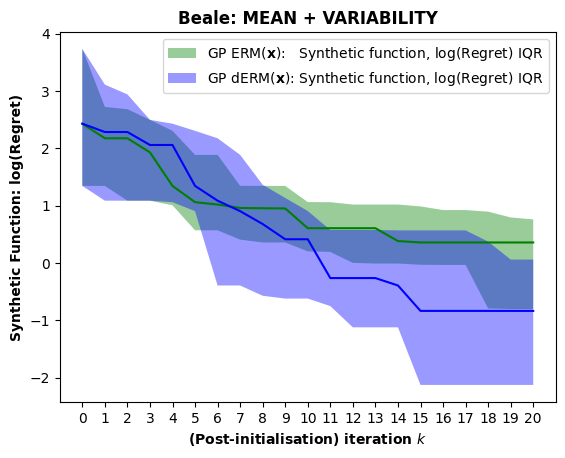

In [163]:
### Visualise!

erm_both = ': MEAN + VARIABILITY'
title = obj_func + erm_both

plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP dERM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


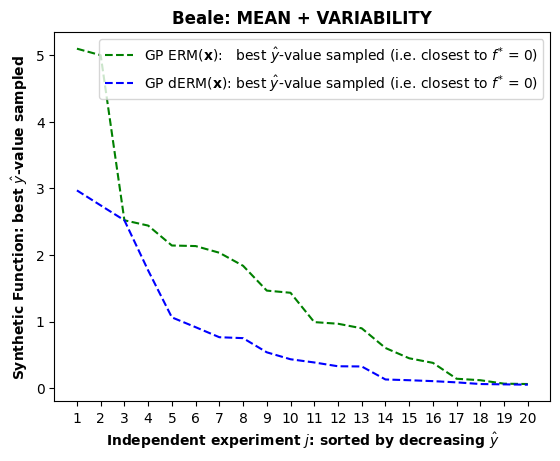

In [164]:
### Visualise!

erm_both = ': MEAN + VARIABILITY'
title = obj_func + erm_both

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Green', ls='--', label='GP ERM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Blue', ls='--', label='GP dERM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


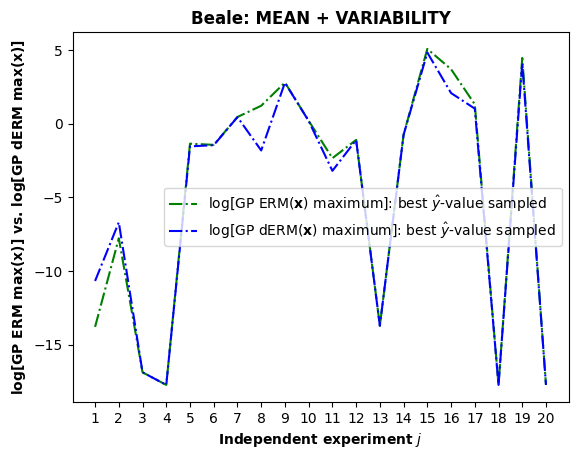

In [165]:
### Visualise!

erm_both = ': MEAN + VARIABILITY'
title = obj_func + erm_both

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Green', ls='-.', label='log[GP ERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Blue', ls='-.', label='log[GP dERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP ERM max($\mathbf{x}$)] vs. log[GP dERM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


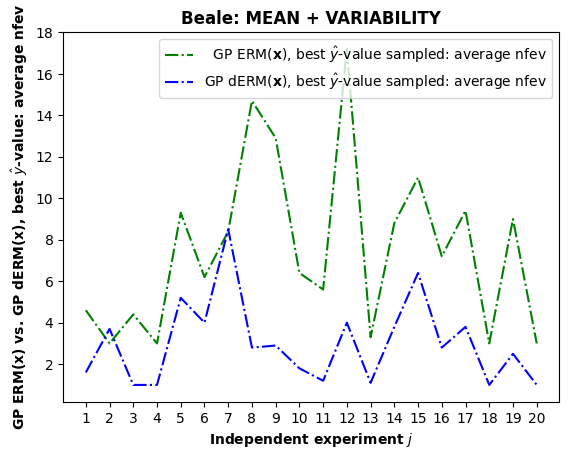

In [166]:
### Visualise!

erm_both = ': MEAN + VARIABILITY'
title = obj_func + erm_both

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


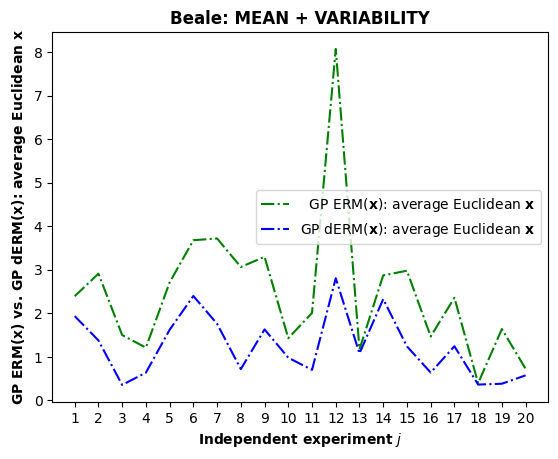

In [167]:
### Visualise!

erm_both = ': MEAN + VARIABILITY'
title = obj_func + erm_both

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 0.0,
 array([-1.21095663, -0.25525958]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 0.0,
 array([-1.21095663, -0.25525958]))

In [170]:
np.round(approx_4.x_best, 4)


array([[-1.211 , -0.2553],
       [-4.3683, -2.832 ],
       [ 0.5022,  1.5938],
       [ 1.3008,  4.028 ],
       [-1.2393,  3.2584],
       [ 2.2579,  1.7829],
       [ 3.094 ,  3.5193],
       [ 1.7737, -3.9383],
       [-2.7917,  0.5702],
       [ 0.4952,  4.2244],
       [ 0.5914,  2.7947],
       [ 1.1803, -3.6823],
       [-1.2694, -0.2297],
       [-3.1738, -0.3069],
       [ 0.7888,  2.6758],
       [ 1.4255,  3.1558],
       [ 3.2391, -3.9201],
       [ 3.8448, -0.6481],
       [ 1.1442, -1.9423],
       [-1.8664, -0.0634]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-1.211 , -0.2553],
       [-4.3683, -2.832 ],
       [ 0.5022,  1.5938],
       [ 1.3008,  4.028 ],
       [-1.2393,  3.2584],
       [ 2.2579,  1.7829],
       [ 3.094 ,  3.5193],
       [ 1.7737, -3.9383],
       [-2.7917,  0.5702],
       [ 0.4952,  4.2244],
       [ 0.5914,  2.7947],
       [ 1.1803, -3.6823],
       [-1.2694, -0.2297],
       [-3.1738, -0.3069],
       [ 0.7888,  2.6758],
       [ 1.4255,  3.1558],
       [ 3.2391, -3.9201],
       [ 3.8448, -0.6481],
       [ 1.1442, -1.9423],
       [-1.8664, -0.0634]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


0.0

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

0.0